# Data

In [1]:
import os
import sys
root_dir = os.path.abspath(os.path.join(os.path.dirname('../full_portfolio_analysis.ipynb'), '..'))
os.chdir(root_dir)
sys.path.insert(0, os.path.join(root_dir, 'src'))

In [2]:

from backbone.utils.wfo_utils import run_strategy, run_wfo
from backbone.utils.general_purpose import calculate_units_size, diff_pips

import itertools
import numpy as np
import pandas as pd
import pandas_ta as pandas_ta
import MetaTrader5 as mt5
import MetaTrader5 as mt5
import pandas as pd
from backtest.get_data import get_data
import pytz
from datetime import datetime
from pandas import Timestamp
import numpy as np
import random
from backtesting import Strategy
from backtesting.lib import crossover
import talib as ta

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

random.seed(42)

In [3]:
INITIAL_CASH = 10_000
MARGIN = 1/30
COMMISSION = 7e-4

timezone = pytz.timezone("Etc/UTC")
date_from_get_data = datetime(2021, 10, 1, tzinfo=timezone)
date_to_get_data = datetime(2024, 9, 1, tzinfo=timezone)

#
limited_testing_start_date = Timestamp('2023-09-01 00:00:00', tz='UTC')
limited_testing_end_date = Timestamp('2024-09-01 00:00:00', tz='UTC')

In [4]:

groups = [
    'Forex_Indicator',
    'CryptoCross_grp',
    'Crypto_group',
    'Energies_group',
    'Forex_group',
    'Indices_group',
    'Stocks_group'
]

In [5]:
if not mt5.initialize():
    print("initialize() failed, error code =",mt5.last_error())
    quit()

symbols = mt5.symbols_get()

tickers = [symbol.path.split('\\')[1] for symbol in symbols if ('Energies_group' in symbol.path or 'Indices_group' in symbol.path or 'Stocks_group' in symbol.path)]

print(tickers)

intervals = [
    mt5.TIMEFRAME_H4,
    mt5.TIMEFRAME_H2,
    mt5.TIMEFRAME_H1,
    # mt5.TIMEFRAME_M15,
]

symbols = get_data(tickers, intervals, date_from_get_data, date_to_get_data)

['UKOILm', 'USOILm', 'AUS200m', 'DE30m', 'FR40m', 'HK50m', 'JP225m', 'STOXX50m', 'UK100m', 'US30m', 'US500m', 'USTECm', 'AAPLm', 'ABBVm', 'ABTm', 'ADBEm', 'ADPm', 'AMDm', 'AMGNm', 'AMTm', 'AMZNm', 'ATVIm', 'AVGOm', 'BAm', 'BABAm', 'BACm', 'BIIBm', 'BMYm', 'Cm', 'CHTRm', 'CMCSAm', 'CMEm', 'COSTm', 'CSCOm', 'CSXm', 'CVSm', 'EAm', 'EBAYm', 'EQIXm', 'Fm', 'FBm', 'GILDm', 'GOOGLm', 'HDm', 'IBMm', 'INTCm', 'INTUm', 'ISRGm', 'JNJm', 'JPMm', 'KOm', 'LINm', 'LLYm', 'LMTm', 'MAm', 'MCDm', 'MDLZm', 'MMMm', 'MOm', 'MRKm', 'MSm', 'MSFTm', 'NFLXm', 'NKEm', 'NVDAm', 'ORCLm', 'PEPm', 'PFEm', 'PGm', 'PMm', 'PYPLm', 'REGNm', 'SBUXm', 'Tm', 'TMOm', 'TMUSm', 'TSLAm', 'UNHm', 'UPSm', 'Vm', 'VRTXm', 'VZm', 'WFCm', 'WMTm', 'XOMm', 'AMCm', 'BBm', 'BBBYm', 'BEKEm', 'BIDUm', 'BILIm', 'BRQSm', 'BYNDm', 'CANm', 'EDUm', 'FTNTm', 'FUTUm', 'IQm', 'JDm', 'LIm', 'NIOm', 'NTESm', 'PDDm', 'RLXm', 'TALm', 'TIGRm', 'TMEm', 'TSMm', 'VIPSm', 'XPEVm', 'YUMCm', 'ZTOm', 'XNGUSDm', 'METAm', 'IN50m']
MetaTrader5 package author: 

In [6]:
max_start_date = None
intervals_start_dates = {}

tickers = np.unique(list(symbols.keys())).tolist()

for interval in intervals:
    for ticker in tickers:
        if not max_start_date or symbols[ticker][interval].index.min() > max_start_date:
            max_start_date = symbols[ticker][interval].index.min()
        
    intervals_start_dates[interval] = max_start_date


intervals_start_dates


print(intervals_start_dates)
print(limited_testing_start_date)
print(limited_testing_end_date)

{16388: Timestamp('2022-03-20 20:00:00+0000', tz='UTC'), 16386: Timestamp('2022-03-20 22:00:00+0000', tz='UTC'), 16385: Timestamp('2022-03-20 22:00:00+0000', tz='UTC')}
2023-09-01 00:00:00+00:00
2024-09-01 00:00:00+00:00


# Estrategia

In [7]:
from backbone.mean_reversion_strategy import MeanReversion

STRATEGY = MeanReversion

# Analisis preliminar

In [8]:
strategies = [
    STRATEGY
]

experiments = list(itertools.product(
    tickers, intervals, strategies
))

stats_per_symbol = {}

performance = pd.DataFrame()

for ticker, interval, strategy in experiments:
    try:
        print(ticker, interval)
        
        if ticker not in stats_per_symbol.keys():
            stats_per_symbol[ticker] = {}
        
        prices = symbols[ticker][interval].loc[limited_testing_start_date:limited_testing_end_date]

        df_stats, stats = run_strategy(
            strategy=strategy,
            ticker=ticker,
            interval=interval,
            commission=COMMISSION, 
            prices=prices, 
            initial_cash=INITIAL_CASH, 
            margin=MARGIN
        )

        performance = pd.concat([performance, df_stats])
        stats_per_symbol[ticker][interval] = stats

    except Exception as e:
        print(f'hubo un problema con {ticker} {interval}: {e}')


performance['return/dd'] = performance['return'] / -performance['drawdown']
performance['drawdown'] = -performance['drawdown']
performance['custom_metric'] = (performance['return'] / (1 + performance.drawdown)) * np.log(1 + performance.trades)


AAPLm 16388
AAPLm 16386
AAPLm 16385
ABBVm 16388
ABBVm 16386
ABBVm 16385
ABTm 16388
ABTm 16386
ABTm 16385
ADBEm 16388
ADBEm 16386
ADBEm 16385
ADPm 16388
ADPm 16386
ADPm 16385
AMDm 16388
AMDm 16386
AMDm 16385
AMGNm 16388
AMGNm 16386
AMGNm 16385
AMTm 16388
AMTm 16386
AMTm 16385
AMZNm 16388
AMZNm 16386
AMZNm 16385
AUS200m 16388
AUS200m 16386
AUS200m 16385
AVGOm 16388
AVGOm 16386
AVGOm 16385
BABAm 16388
BABAm 16386
BABAm 16385
BACm 16388
BACm 16386
BACm 16385
BAm 16388
BAm 16386
BAm 16385
BBm 16388
BBm 16386
BBm 16385
BEKEm 16388
BEKEm 16386
BEKEm 16385
BIDUm 16388
BIDUm 16386
BIDUm 16385
BIIBm 16388
BIIBm 16386
BIIBm 16385
BILIm 16388
BILIm 16386
BILIm 16385
BMYm 16388
BMYm 16386
BMYm 16385
CHTRm 16388
CHTRm 16386
CHTRm 16385
CMCSAm 16388
CMCSAm 16386
CMCSAm 16385
CMEm 16388
CMEm 16386
CMEm 16385
COSTm 16388
COSTm 16386
COSTm 16385
CSCOm 16388
CSCOm 16386
CSCOm 16385
CSXm 16388
CSXm 16386
CSXm 16385
CVSm 16388
CVSm 16386
CVSm 16385
Cm 16388
Cm 16386
Cm 16385
DE30m 16388
DE30m 16386
DE30m 1

c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\backbone\utils\wfo_utils.py:84: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  bt_train = Backtest(
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\backbone\utils\wfo_utils.py:84: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  bt_train = Backtest(


JP225m 16385


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\backbone\utils\wfo_utils.py:84: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  bt_train = Backtest(


JPMm 16388
JPMm 16386
JPMm 16385
KOm 16388
KOm 16386
KOm 16385
LINm 16388
LINm 16386
LINm 16385
LIm 16388
LIm 16386
LIm 16385
LLYm 16388
LLYm 16386
LLYm 16385
LMTm 16388
LMTm 16386
LMTm 16385
MAm 16388
MAm 16386
MAm 16385
MCDm 16388
MCDm 16386
MCDm 16385
MDLZm 16388
MDLZm 16386
MDLZm 16385
METAm 16388
METAm 16386
METAm 16385
MMMm 16388
MMMm 16386
MMMm 16385
MOm 16388
MOm 16386
MOm 16385
MRKm 16388
MRKm 16386
MRKm 16385
MSFTm 16388
MSFTm 16386
MSFTm 16385
MSm 16388
MSm 16386
MSm 16385
NFLXm 16388
NFLXm 16386
NFLXm 16385
NIOm 16388
NIOm 16386
NIOm 16385
NKEm 16388
NKEm 16386
NKEm 16385
NTESm 16388
NTESm 16386
NTESm 16385
NVDAm 16388
NVDAm 16386
NVDAm 16385
ORCLm 16388
ORCLm 16386
ORCLm 16385
PDDm 16388
PDDm 16386
PDDm 16385
PEPm 16388
PEPm 16386
PEPm 16385
PFEm 16388
PFEm 16386
PFEm 16385
PGm 16388
PGm 16386
PGm 16385
PMm 16388
PMm 16386
PMm 16385
PYPLm 16388
PYPLm 16386
PYPLm 16385
REGNm 16388
REGNm 16386
REGNm 16385
RLXm 16388
RLXm 16386
RLXm 16385
SBUXm 16388
SBUXm 16386
SBUXm 16385
S

In [9]:

filter_performance = performance[
    (performance['return/dd']>2)
    & (performance['stability_ratio']>0.6)
].sort_values(by=['return/dd'], ascending=[False]).drop_duplicates(subset=['ticker'], keep='first')

portfolio = filter_performance.ticker.tolist()
intervals = filter_performance.interval.values.tolist()

display(filter_performance)

# portfolio

,strategy,ticker,interval,stability_ratio,return,final_eq,drawdown,drawdown_duration,win_rate,sharpe_ratio,trades,avg_trade_percent,exposure,final_equity,Duration,return/dd,custom_metric
0,MeanReversion,CSCOm,16388,0.815576,18.106253,11810.625344,3.113079,119 days 00:00:00,55.172414,1.462846,29,1.026164,60.580205,11810.625344,364 days 04:00:00,5.816188,14.972467
0,MeanReversion,NTESm,16385,0.840912,51.454015,15145.401518,10.405453,103 days 00:00:00,53.225806,1.721184,124,0.626200,63.417891,15145.401518,364 days 08:00:00,4.944909,21.782223
0,MeanReversion,IQm,16386,0.747833,20.309927,12030.992673,4.584796,82 days 22:00:00,53.571429,1.544643,84,0.616995,65.200000,12030.992673,364 days 06:00:00,4.429843,16.156350
0,MeanReversion,UNHm,16388,0.861122,20.192267,12019.226709,5.597520,51 days 04:00:00,53.846154,1.629011,26,1.015974,69.795222,12019.226709,364 days 04:00:00,3.607359,10.087187
0,MeanReversion,ADBEm,16388,0.800043,13.904655,11390.465519,4.193443,57 days 16:00:00,54.545455,1.202500,33,0.927390,73.208191,11390.465519,364 days 04:00:00,3.315808,9.441294
0,MeanReversion,CMCSAm,16388,0.803172,13.822312,11382.231166,4.283859,110 days 20:00:00,67.741935,1.788668,31,1.072660,51.365188,11382.231166,364 days 04:00:00,3.226603,9.066193
0,MeanReversion,PGm,16388,0.712778,10.066590,11006.658972,3.271867,130 days 16:00:00,60.869565,1.211063,23,0.473708,68.600683,11006.658972,364 days 04:00:00,3.076711,7.489036
0,MeanReversion,UPSm,16385,0.753335,26.912740,12691.273973,10.726586,90 days 18:00:00,50.000000,1.413386,80,0.420147,62.685714,12691.273973,364 days 06:00:00,2.508975,10.085345


In [15]:
# for ticker, interval in zip(portfolio, intervals):
    
#     prices = symbols[ticker][interval].loc[limited_testing_start_date:limited_testing_end_date]

#     df_stats = run_strategy(
#         strategy=strategy,
#         ticker=ticker,
#         interval=interval,
#         commission=COMMISSION, 
#         prices=prices, 
#         initial_cash=INITIAL_CASH, 
#         margin=MARGIN,
#         plot=True
#     )


# WFO

In [14]:
from backbone.utils.wfo_utils import optimization_function

lookback_bars = 1500
validation_bars = 100
warmup_bars = 50

all_wfo_performances = pd.DataFrame()
all_opt_params = {}

params = {
    'deviation_threshold': list(np.arange(0.01, 0.2, 0.02).round(2)),
    'atr_multiplier' : [1.5, 1.8, 2, 2.5, 1.8, 3],
}

for index, row in filter_performance.iterrows():
    
    try:
        ticker = row.ticker
        interval = row.interval
        
        print(ticker, interval)
        
        prices = symbols[ticker][interval]

        wfo_stats, df_stats, opt_params = run_wfo(
            strategy=STRATEGY,
            ticker=ticker,
            interval=interval,
            prices=prices,
            initial_cash=INITIAL_CASH,
            commission=COMMISSION,
            margin=MARGIN,
            optim_func=optimization_function,
            params=params,
            lookback_bars=lookback_bars,
            warmup_bars=warmup_bars,
            validation_bars=validation_bars,
            plot=False
        )
                
        if ticker not in all_opt_params.keys():
            all_opt_params[ticker] = {}

        all_opt_params[ticker][interval] = opt_params

        all_wfo_performances = pd.concat([all_wfo_performances, df_stats])
    
    except Exception as e:
        print(f'No se pudo ejecutar para el ticker {ticker}: {e}')
    
all_wfo_performances['return/dd'] = all_wfo_performances['return'] / -all_wfo_performances['drawdown']
all_wfo_performances['drawdown'] = -all_wfo_performances['drawdown']
all_wfo_performances['custom_metric'] = (all_wfo_performances['return'] / (1 + all_wfo_performances.drawdown)) * np.log(1 + all_wfo_performances.trades)

all_wfo_performances.drawdown_duration = pd.to_timedelta(all_wfo_performances.drawdown_duration)
all_wfo_performances.drawdown_duration = all_wfo_performances.drawdown_duration.dt.days

CSCOm 16388
NTESm 16385
IQm 16386
UNHm 16388
ADBEm 16388
CMCSAm 16388
PGm 16388


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_stats.py:122: RuntimeWarning: invalid value encountered in scalar divide
  s.loc['Sortino Ratio'] = np.clip((annualized_return - risk_free_rate) / (np.sqrt(np.mean(day_returns.clip(-np.inf, 0)**2)) * np.sqrt(annual_trading_days)), 0, np.inf)  # noqa: E501


UPSm 16385


In [15]:

performance = pd.DataFrame()

wfo_stats_per_symbol = {}

for index, row in filter_performance.iterrows():
    try:
        ticker = row.ticker
        interval = row.interval
        print(ticker, interval)
        
        prices = symbols[ticker][interval]
        params = all_opt_params[ticker][interval]
        
        if ticker not in wfo_stats_per_symbol.keys():
            wfo_stats_per_symbol[ticker] = {}

        df_stats, wfo_stats = run_strategy(
            strategy=strategy,
            ticker=ticker,
            interval=interval,
            commission=COMMISSION, 
            prices=prices, 
            initial_cash=INITIAL_CASH, 
            margin=MARGIN, 
            opt_params=params, 
            plot=True
        )

        wfo_stats_per_symbol[ticker][interval] = wfo_stats

        performance = pd.concat([performance, df_stats])

    except Exception as e:
        print(f'hubo un problema con {ticker} {interval}: {e}')


performance['return/dd'] = performance['return'] / -performance['drawdown']
performance['drawdown'] = -performance['drawdown']
performance['custom_metric'] = (performance['return'] / (1 + performance.drawdown)) * np.log(1 + performance.trades)


CSCOm 16388


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


NTESm 16385


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


IQm 16386


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


UNHm 16388


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


ADBEm 16388


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


CMCSAm 16388


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


PGm 16388


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


UPSm 16385


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


In [16]:
filtered_wfo_performance = performance[
    (performance['stability_ratio'] > 0.6)
    & (performance['return/dd'] > 1)
].sort_values(by='return/dd', ascending=False)

filtered_wfo_performance

,strategy,ticker,interval,stability_ratio,return,final_eq,drawdown,drawdown_duration,win_rate,sharpe_ratio,trades,avg_trade_percent,exposure,final_equity,Duration,return/dd,custom_metric
0,MeanReversion,UNHm,16388,0.847622,37.995226,13799.522572,6.681301,135 days 00:00:00,50.574713,1.226063,87,0.693274,69.326980,13799.522572,1038 days 00:00:00,5.686800,22.146954
0,MeanReversion,IQm,16386,0.811351,30.552224,13055.222395,12.454574,399 days 18:00:00,48.387097,0.796512,186,0.163523,67.217728,13055.222395,1038 days 02:00:00,2.453093,11.878637


# Montecarlo

In [17]:
# Crear una lista para almacenar los resultados de cada ticker
from backbone.utils.montecarlo_utils import montecarlo_statistics_simulation

data_drawdown = []
data_return = []
montecarlo_simulations = {}

all_drawdowns = pd.DataFrame()
all_returns = pd.DataFrame()

for index, row in filtered_wfo_performance.iterrows():
    ticker = row.ticker
    interval = row.interval
    
    print(f"Procesando ticker: {ticker}")
    trades_history = stats_per_symbol[ticker][interval]._trades
    eq_curve = stats_per_symbol[ticker][interval]._equity_curve
    
    # Simulación de Montecarlo para cada ticker (datos agregados)
    mc, synthetic_drawdown_curve, synthetic_return_curve = montecarlo_statistics_simulation(
        equity_curve=eq_curve,
        trade_history=trades_history, 
        n_simulations=100_000, 
        initial_equity=INITIAL_CASH, 
        threshold_ruin=0.8, 
        return_raw_curves=True,
        percentiles=[0.1, 0.25, 0.5, 0.75, 0.9]
    )
    
    montecarlo_simulations[ticker] = mc
    
    synthetic_drawdown_curve['ticker'] = ticker
    synthetic_return_curve['ticker'] = ticker
    
    all_drawdowns = pd.concat([all_drawdowns, synthetic_drawdown_curve])
    all_returns = pd.concat([all_returns, synthetic_return_curve])

Procesando ticker: UNHm
Procesando ticker: IQm


In [18]:
dd_df = pd.DataFrame()
returns_df = pd.DataFrame()

for ticker, mc in montecarlo_simulations.items():
    mc = mc.rename(
        columns={
            'Drawdown (%)': f'drawdown_{ticker}',
            'Final Return (%)': f'return_{ticker}',
        }
    )

    if dd_df.empty:
        dd_df = mc[[f'drawdown_{ticker}']]
    
    else:
        dd_df = pd.merge(
            dd_df,
            mc[[f'drawdown_{ticker}']],
            left_index=True,
            right_index=True            
        )
        
    if returns_df.empty:
        returns_df = mc[[f'return_{ticker}']]
    
    else:
        returns_df = pd.merge(
            returns_df,
            mc[[f'return_{ticker}']],
            left_index=True,
            right_index=True            
        )
        
display(dd_df)
display(returns_df)


,drawdown_UNHm,drawdown_IQm
count,100000.000000,100000.000000
mean,-5.376025,-8.330470
std,2.595470,3.386523
min,-28.513724,-32.727766
10%,-8.809071,-12.885574
25%,-6.673774,-10.053916
50%,-4.856121,-7.656694
75%,-3.534010,-5.889171
90%,-2.620250,-4.701744
max,0.000000,-1.964597


,return_UNHm,return_IQm
count,100000.000000,100000.000000
mean,23.830390,19.189221
std,13.351327,14.693417
min,-23.270402,-30.587101
10%,7.310346,1.045150
25%,14.522656,8.858020
50%,23.168181,18.325561
75%,32.326002,28.495667
90%,41.292354,38.470486
max,94.450820,102.460560


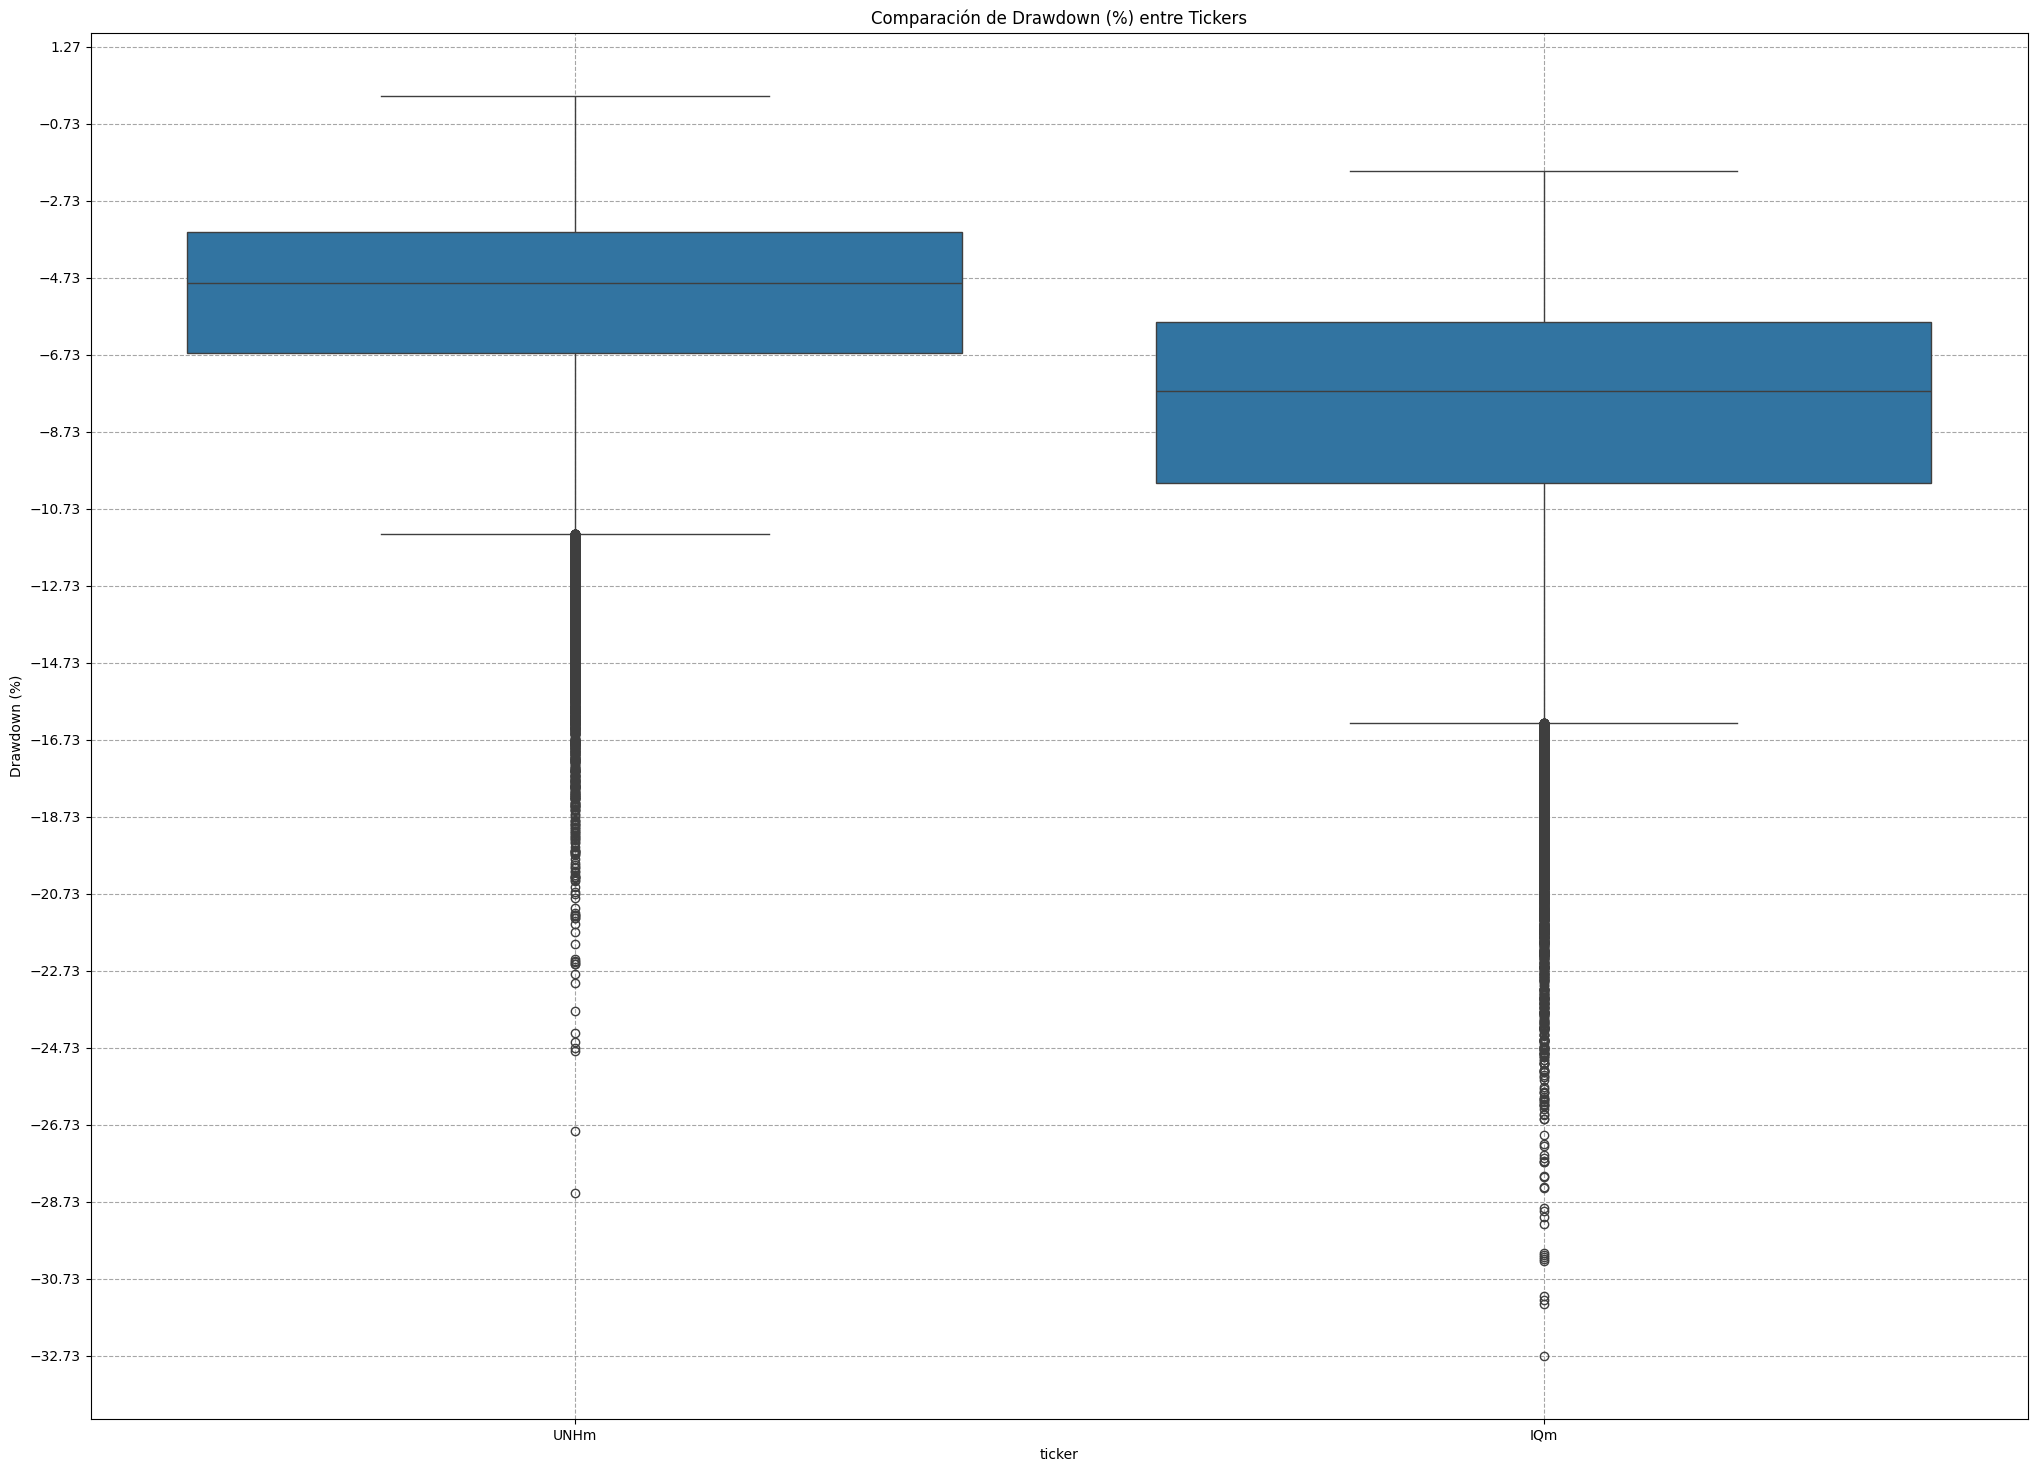

In [19]:
# Configurar el gráfico con matplotlib y seaborn
plt.figure(figsize=(25, 18))
sns.boxplot(data=all_drawdowns, x="ticker", y="Drawdown (%)")
plt.title("Comparación de Drawdown (%) entre Tickers")

y_max = all_drawdowns["Drawdown (%)"].max()  # Valor máximo en el eje Y
y_min = all_drawdowns["Drawdown (%)"].min()  # Valor mínimo en el eje Y
tick_interval = 2  # Intervalo deseado entre números en el eje Y

# Configurar los ticks mayores en el eje Y
plt.yticks(np.arange(y_min, y_max + tick_interval, tick_interval))

# Activar la cuadrícula
plt.grid(True, linestyle='--', which='both', color='grey', alpha=0.7)

# Mostrar el gráfico
plt.show()


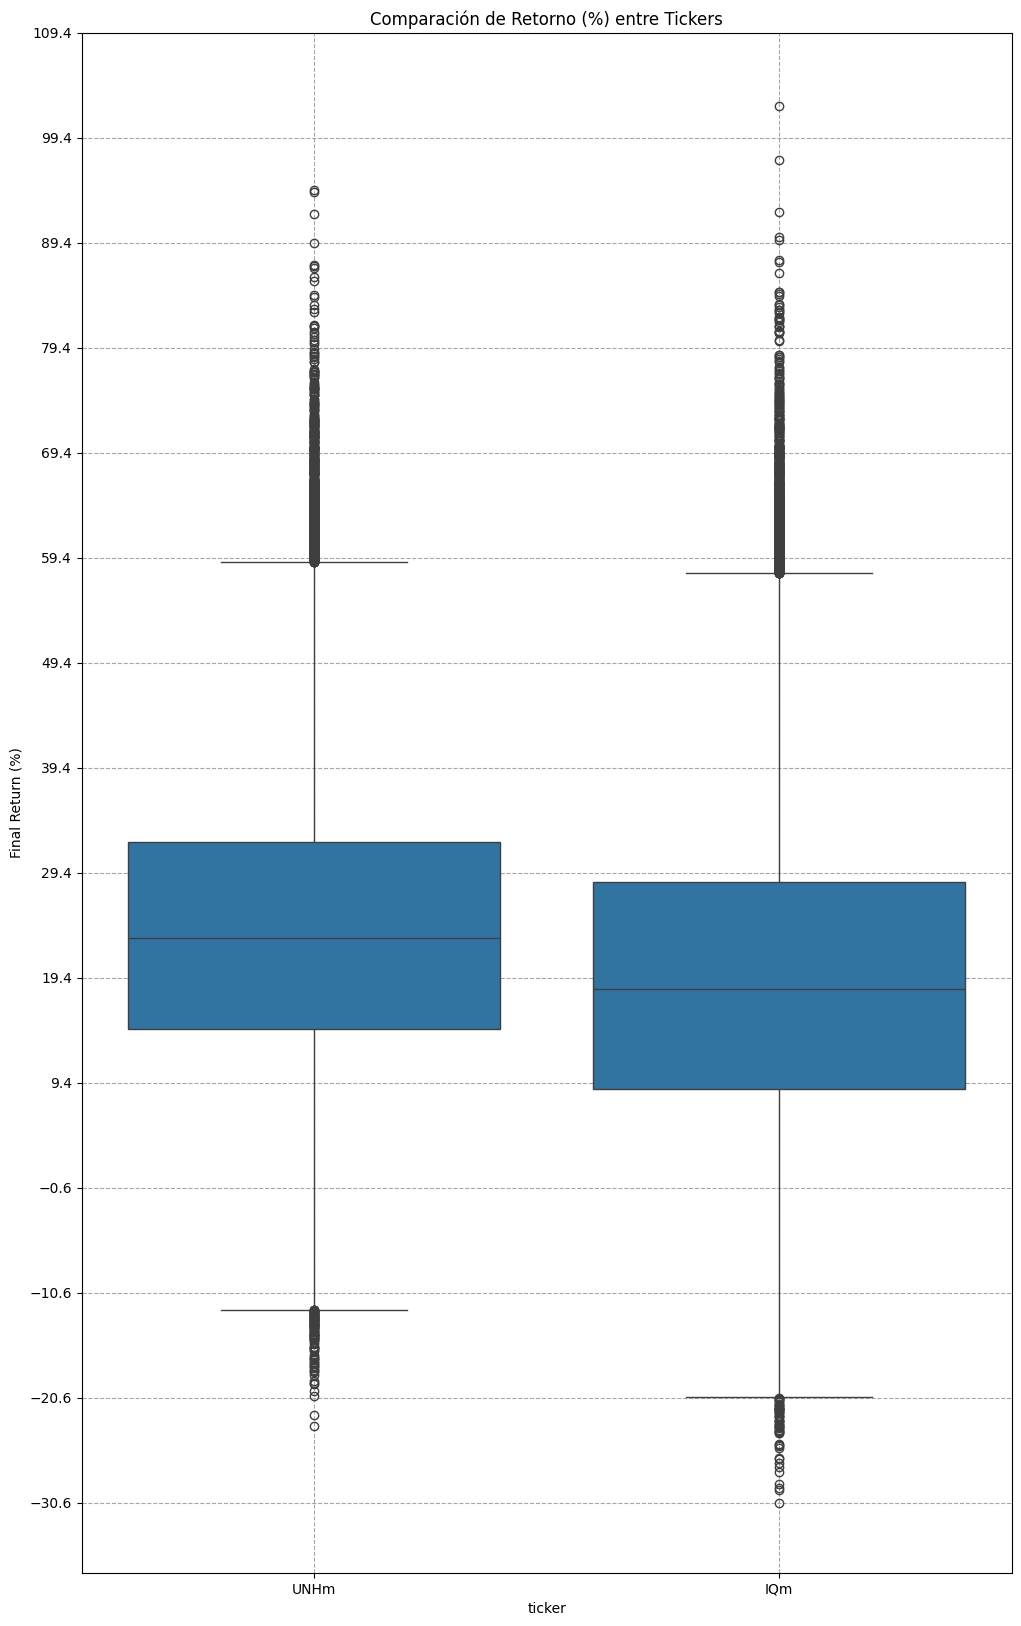

In [20]:
# Generar el gráfico
plt.figure(figsize=(12, 20))
sns.boxplot(data=all_returns, x="ticker", y="Final Return (%)")
plt.title("Comparación de Retorno (%) entre Tickers")

# Configurar ticks mayores con más números
y_max = all_returns["Final Return (%)"].max()  # Valor máximo en el eje Y
y_min = all_returns["Final Return (%)"].min()  # Valor mínimo en el eje Y
tick_interval = 10  # Intervalo deseado entre números en el eje Y

# Configurar los ticks mayores en el eje Y
plt.yticks(np.arange(y_min, y_max + tick_interval, tick_interval))

# Activar la cuadrícula
plt.grid(True, linestyle='--', which='both', color='grey', alpha=0.7)

# Mostrar el gráfico
plt.show()
